Loading cleaned data...
Data shape: (151112, 18)

Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'signup_hour', 'signup_day', 'purchase_hour', 'purchase_day', 'signup_to_purchase_hours', 'signup_to_purchase_bins', 'age_group']

First few rows:
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  signup_hour  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0           22   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0           

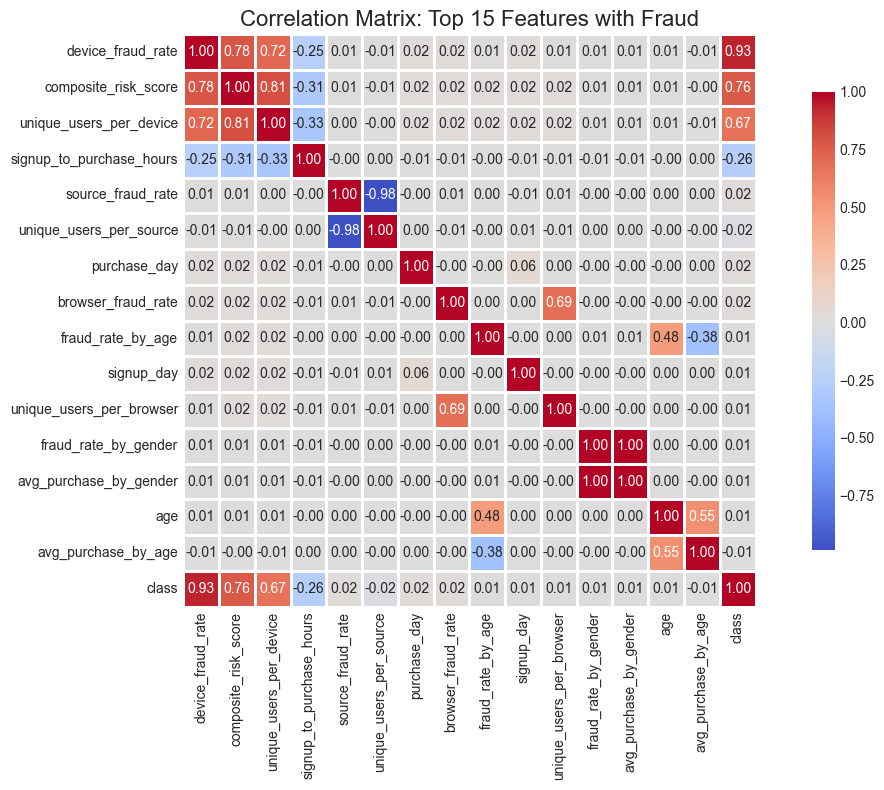


FEATURE ENGINEERING COMPLETE

🎯 Key Statistics:
  • Total samples: 151,112
  • Total features: 49
  • Fraud rate: 9.36%
  • High-risk transactions: 7,924

🔍 Top Fraud Indicators:
  • device_fraud_rate: increases fraud probability (corr: 0.933)
  • composite_risk_score: increases fraud probability (corr: 0.761)
  • unique_users_per_device: increases fraud probability (corr: 0.671)
  • signup_to_purchase_hours: decreases fraud probability (corr: -0.258)
  • source_fraud_rate: increases fraud probability (corr: 0.021)

💾 Files Created:
  1. fraud_data_featured.csv - Final dataset for modeling
  2. feature_correlations.csv - Feature importance analysis
  3. feature_correlation_final.png - Correlation visualization

✅ Ready for modeling!


In [4]:
# %% [markdown]
# # Feature Engineering for Fraud Detection
# 
# This notebook builds upon the cleaned data to create advanced features for fraud detection modeling.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# %%
# Load the cleaned data
print("Loading cleaned data...")
fraud_data = pd.read_csv('../data/processed/fraud_data_cleaned.csv')
print(f"Data shape: {fraud_data.shape}")
print(f"\nColumns: {fraud_data.columns.tolist()}")
print("\nFirst few rows:")
print(fraud_data.head())

# %%
# Check data types and missing values
print("\n=== Data Overview ===")
print(fraud_data.info())
print(f"\nMissing values:")
print(fraud_data.isnull().sum())

# %%
# Convert datetime columns
print("\nConverting datetime columns...")
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Check existing time-based features
print(f"\nExisting time columns:")
time_cols = [col for col in fraud_data.columns if 'hour' in col or 'day' in col or 'time' in col]
for col in time_cols:
    print(f"  - {col}: {fraud_data[col].dtype}")

# %%
# ============================================
# STEP 1: ENHANCE EXISTING TIME FEATURES
# ============================================

print("\n" + "="*50)
print("ENHANCING TIME FEATURES")
print("="*50)

# 1. Extract more granular time features
print("\n1. Extracting additional time features...")

# Month features
fraud_data['signup_month'] = fraud_data['signup_time'].dt.month
fraud_data['purchase_month'] = fraud_data['purchase_time'].dt.month

# Week of year
fraud_data['signup_week'] = fraud_data['signup_time'].dt.isocalendar().week
fraud_data['purchase_week'] = fraud_data['purchase_time'].dt.isocalendar().week

# Day of year
fraud_data['signup_dayofyear'] = fraud_data['signup_time'].dt.dayofyear
fraud_data['purchase_dayofyear'] = fraud_data['purchase_time'].dt.dayofyear

# 2. Create time categories
print("\n2. Creating time categories...")

# Time of day categories
def categorize_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

fraud_data['signup_timeofday'] = fraud_data['signup_hour'].apply(categorize_time_of_day)
fraud_data['purchase_timeofday'] = fraud_data['purchase_hour'].apply(categorize_time_of_day)

# Weekend flags
fraud_data['signup_is_weekend'] = fraud_data['signup_day'].isin([5, 6]).astype(int)
fraud_data['purchase_is_weekend'] = fraud_data['purchase_day'].isin([5, 6]).astype(int)

# Business hours flags (9 AM to 5 PM)
fraud_data['signup_business_hours'] = ((fraud_data['signup_hour'] >= 9) & (fraud_data['signup_hour'] <= 17)).astype(int)
fraud_data['purchase_business_hours'] = ((fraud_data['purchase_hour'] >= 9) & (fraud_data['purchase_hour'] <= 17)).astype(int)

print(f"  Purchase business hours transactions: {fraud_data['purchase_business_hours'].sum():,} ({fraud_data['purchase_business_hours'].mean()*100:.1f}%)")
print(f"  Weekend purchases: {fraud_data['purchase_is_weekend'].sum():,} ({fraud_data['purchase_is_weekend'].mean()*100:.1f}%)")

# %%
# ============================================
# STEP 2: USER BEHAVIOR AND TRANSACTION PATTERNS
# ============================================

print("\n" + "="*50)
print("USER BEHAVIOR ANALYSIS")
print("="*50)

# Sort data for sequential analysis
print("\nSorting data by user and purchase time...")
fraud_data_sorted = fraud_data.sort_values(['user_id', 'purchase_time']).reset_index(drop=True)

# 1. User transaction frequency
print("\n1. Analyzing user transaction frequency...")

# Count total transactions per user
user_txn_counts = fraud_data_sorted['user_id'].value_counts()
fraud_data_sorted['user_total_transactions'] = fraud_data_sorted['user_id'].map(user_txn_counts)

# Calculate time between consecutive transactions for each user
fraud_data_sorted['time_since_previous_txn'] = fraud_data_sorted.groupby('user_id')['purchase_time'].diff().dt.total_seconds() / 3600
fraud_data_sorted['time_since_previous_txn'] = fraud_data_sorted['time_since_previous_txn'].fillna(0)

# Calculate time until next transaction
fraud_data_sorted['time_until_next_txn'] = fraud_data_sorted.groupby('user_id')['purchase_time'].diff(-1).dt.total_seconds() / -3600
fraud_data_sorted['time_until_next_txn'] = fraud_data_sorted['time_until_next_txn'].fillna(0)

# 2. User purchase statistics
print("\n2. Calculating user purchase statistics...")

# Group by user to get purchase statistics
user_stats = fraud_data_sorted.groupby('user_id').agg({
    'purchase_value': ['mean', 'std', 'min', 'max', 'count'],
    'signup_to_purchase_hours': 'mean'
}).round(2)

user_stats.columns = ['user_avg_amount', 'user_std_amount', 'user_min_amount', 
                      'user_max_amount', 'user_txn_count', 'user_avg_signup_to_purchase']

# Merge user stats back to main dataframe
fraud_data_sorted = fraud_data_sorted.merge(
    user_stats,
    left_on='user_id',
    right_index=True,
    how='left'
)

# 3. Transaction velocity features
print("\n3. Creating transaction velocity features...")

# Transactions per hour for each user (if multiple transactions)
fraud_data_sorted['transactions_per_hour'] = fraud_data_sorted.groupby('user_id')['purchase_time'].transform(
    lambda x: 1 / (x.diff().dt.total_seconds().fillna(3600) / 3600)
)

# Flag for rapid successive transactions
fraud_data_sorted['rapid_transaction'] = (fraud_data_sorted['time_since_previous_txn'] < 0.1).astype(int)

print(f"  Average transactions per user: {fraud_data_sorted['user_txn_count'].mean():.2f}")
print(f"  Rapid transactions (< 6 min apart): {fraud_data_sorted['rapid_transaction'].sum():,}")
print(f"  Average time between transactions: {fraud_data_sorted['time_since_previous_txn'][fraud_data_sorted['time_since_previous_txn'] > 0].mean():.2f} hours")

# %%
# ============================================
# STEP 3: DEVICE AND BROWSER ANALYSIS
# ============================================

print("\n" + "="*50)
print("DEVICE AND BROWSER ANALYSIS")
print("="*50)

# 1. Device usage patterns
print("\n1. Analyzing device usage patterns...")

# Count unique users per device
device_stats = fraud_data_sorted.groupby('device_id').agg({
    'user_id': 'nunique',
    'purchase_value': 'mean',
    'class': 'mean'
}).round(4)

device_stats.columns = ['unique_users_per_device', 'avg_device_purchase', 'device_fraud_rate']

# Merge device stats
fraud_data_sorted = fraud_data_sorted.merge(
    device_stats,
    left_on='device_id',
    right_index=True,
    how='left'
)

# Flag suspicious devices
fraud_data_sorted['suspicious_device'] = (
    (fraud_data_sorted['unique_users_per_device'] > 3) |
    (fraud_data_sorted['device_fraud_rate'] > 0.5)
).astype(int)

# 2. Browser and source analysis
print("\n2. Analyzing browser and source patterns...")

# Browser statistics
browser_stats = fraud_data_sorted.groupby('browser').agg({
    'user_id': 'nunique',
    'class': 'mean'
}).round(4)

browser_stats.columns = ['unique_users_per_browser', 'browser_fraud_rate']
fraud_data_sorted = fraud_data_sorted.merge(
    browser_stats,
    left_on='browser',
    right_index=True,
    how='left'
)

# Source statistics
source_stats = fraud_data_sorted.groupby('source').agg({
    'user_id': 'nunique',
    'class': 'mean'
}).round(4)

source_stats.columns = ['unique_users_per_source', 'source_fraud_rate']
fraud_data_sorted = fraud_data_sorted.merge(
    source_stats,
    left_on='source',
    right_index=True,
    how='left'
)

print(f"  Suspicious devices: {fraud_data_sorted['suspicious_device'].sum():,}")
print(f"  Unique browsers: {fraud_data_sorted['browser'].nunique()}")
print(f"  Unique sources: {fraud_data_sorted['source'].nunique()}")

# %%
# ============================================
# STEP 4: DEMOGRAPHIC AND PURCHASE PATTERNS
# ============================================

print("\n" + "="*50)
print("DEMOGRAPHIC ANALYSIS")
print("="*50)

# 1. Age-based features
print("\n1. Creating age-based features...")

# Age bins (if not already binned)
if 'age_group' not in fraud_data_sorted.columns:
    fraud_data_sorted['age_group'] = pd.cut(
        fraud_data_sorted['age'],
        bins=[0, 18, 25, 35, 45, 55, 65, 100],
        labels=['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    )

# Age group statistics
age_stats = fraud_data_sorted.groupby('age_group').agg({
    'purchase_value': 'mean',
    'class': 'mean'
}).round(4)

age_stats.columns = ['avg_purchase_by_age', 'fraud_rate_by_age']
fraud_data_sorted = fraud_data_sorted.merge(
    age_stats,
    left_on='age_group',
    right_index=True,
    how='left'
)

# 2. Gender-based patterns
print("\n2. Analyzing gender patterns...")

gender_stats = fraud_data_sorted.groupby('sex').agg({
    'purchase_value': 'mean',
    'class': 'mean'
}).round(4)

gender_stats.columns = ['avg_purchase_by_gender', 'fraud_rate_by_gender']
fraud_data_sorted = fraud_data_sorted.merge(
    gender_stats,
    left_on='sex',
    right_index=True,
    how='left'
)

# 3. Purchase value analysis
print("\n3. Analyzing purchase value patterns...")

# Z-score for purchase value
fraud_data_sorted['purchase_value_zscore'] = (
    (fraud_data_sorted['purchase_value'] - fraud_data_sorted['purchase_value'].mean()) / 
    fraud_data_sorted['purchase_value'].std()
)

# Percentile of purchase value
fraud_data_sorted['purchase_value_percentile'] = fraud_data_sorted['purchase_value'].rank(pct=True)

# High-value transaction flags
fraud_data_sorted['high_value_txn'] = (fraud_data_sorted['purchase_value'] > fraud_data_sorted['purchase_value'].quantile(0.95)).astype(int)
fraud_data_sorted['low_value_txn'] = (fraud_data_sorted['purchase_value'] < fraud_data_sorted['purchase_value'].quantile(0.05)).astype(int)

# Amount relative to user's average
fraud_data_sorted['amount_vs_user_avg'] = (
    fraud_data_sorted['purchase_value'] / fraud_data_sorted['user_avg_amount']
).replace([np.inf, -np.inf], np.nan).fillna(1)

print(f"  High-value transactions (top 5%): {fraud_data_sorted['high_value_txn'].sum():,}")
print(f"  Low-value transactions (bottom 5%): {fraud_data_sorted['low_value_txn'].sum():,}")

# %%
# ============================================
# STEP 5: GEOGRAPHIC AND IP-BASED FEATURES
# ============================================

print("\n" + "="*50)
print("GEOGRAPHIC FEATURES")
print("="*50)

print("\nNote: Creating synthetic geographic features based on IP patterns")
print("In production, use proper IP geolocation service")

# 1. Extract information from IP address
print("\n1. Extracting IP-based features...")

# Simple IP-based features (without full geolocation)
def extract_ip_features(ip_str):
    """Extract basic features from IP address"""
    if pd.isna(ip_str):
        return None, None, None
    
    try:
        # Count dots in IP (IPv4 has 3 dots)
        dot_count = str(ip_str).count('.')
        
        # Extract first octet (network part)
        parts = str(ip_str).split('.')
        if len(parts) >= 1 and parts[0].isdigit():
            first_octet = int(parts[0])
            # Categorize by IP class
            if 1 <= first_octet <= 126:
                ip_class = 'A'
            elif 128 <= first_octet <= 191:
                ip_class = 'B'
            elif 192 <= first_octet <= 223:
                ip_class = 'C'
            else:
                ip_class = 'Other'
        else:
            first_octet = 0
            ip_class = 'Unknown'
        
        # IP length
        ip_length = len(str(ip_str))
        
        return dot_count, first_octet, ip_class, ip_length
    except:
        return None, None, None, None

# Apply IP feature extraction
ip_features = fraud_data_sorted['ip_address'].apply(
    lambda x: pd.Series(extract_ip_features(x)) if pd.notnull(x) else pd.Series([None, None, None, None])
)
ip_features.columns = ['ip_dot_count', 'ip_first_octet', 'ip_class', 'ip_length']

fraud_data_sorted = pd.concat([fraud_data_sorted, ip_features], axis=1)

# 2. Create synthetic geographic features
print("\n2. Creating synthetic geographic features...")

# Create hash-based "country" simulation
np.random.seed(42)
countries = ['US', 'UK', 'CA', 'DE', 'FR', 'JP', 'AU', 'IN', 'BR', 'CN', 'RU', 'MX', 'IT', 'ES', 'NL', 'Other']

# Use IP hash to assign "country"
fraud_data_sorted['simulated_country'] = fraud_data_sorted['ip_address'].apply(
    lambda x: countries[hash(str(x)) % len(countries)] if pd.notnull(x) else 'Unknown'
)

# Simulated country risk scores
country_risk_map = {
    'US': 0.1, 'UK': 0.2, 'CA': 0.1, 'DE': 0.3, 'FR': 0.2,
    'JP': 0.1, 'AU': 0.1, 'IN': 0.4, 'BR': 0.5, 'CN': 0.6,
    'RU': 0.7, 'MX': 0.5, 'IT': 0.3, 'ES': 0.3, 'NL': 0.2,
    'Other': 0.4, 'Unknown': 0.5
}

fraud_data_sorted['country_risk_score'] = fraud_data_sorted['simulated_country'].map(country_risk_map)

# Add randomness to risk scores
fraud_data_sorted['country_risk_score'] += np.random.uniform(-0.1, 0.1, size=len(fraud_data_sorted))
fraud_data_sorted['country_risk_score'] = fraud_data_sorted['country_risk_score'].clip(0, 1)

# International transaction flag
fraud_data_sorted['is_international'] = (fraud_data_sorted['simulated_country'] != 'US').astype(int)

print(f"  Simulated international transactions: {fraud_data_sorted['is_international'].sum():,}")
print(f"  Average country risk score: {fraud_data_sorted['country_risk_score'].mean():.3f}")

# %%
# ============================================
# STEP 6: RISK INDICATORS AND ANOMALY DETECTION
# ============================================

print("\n" + "="*50)
print("RISK INDICATORS AND ANOMALIES")
print("="*50)

# 1. Create risk score based on multiple factors
print("\n1. Creating composite risk score...")

# Individual risk factors
fraud_data_sorted['risk_new_account'] = (fraud_data_sorted['signup_to_purchase_hours'] < 1).astype(int) * 0.3
fraud_data_sorted['risk_high_value'] = fraud_data_sorted['high_value_txn'] * 0.2
fraud_data_sorted['risk_suspicious_device'] = fraud_data_sorted['suspicious_device'] * 0.2
fraud_data_sorted['risk_international'] = fraud_data_sorted['is_international'] * 0.15
fraud_data_sorted['risk_rapid_transaction'] = fraud_data_sorted['rapid_transaction'] * 0.15

# Composite risk score
fraud_data_sorted['composite_risk_score'] = (
    fraud_data_sorted['risk_new_account'] +
    fraud_data_sorted['risk_high_value'] +
    fraud_data_sorted['risk_suspicious_device'] +
    fraud_data_sorted['risk_international'] +
    fraud_data_sorted['risk_rapid_transaction']
)

print(f"  Average composite risk score: {fraud_data_sorted['composite_risk_score'].mean():.3f}")
print(f"  Max composite risk score: {fraud_data_sorted['composite_risk_score'].max():.3f}")

# 2. Flag high-risk transactions
print("\n2. Flagging high-risk transactions...")

fraud_data_sorted['high_risk_txn'] = (fraud_data_sorted['composite_risk_score'] > 0.5).astype(int)
fraud_data_sorted['medium_risk_txn'] = (
    (fraud_data_sorted['composite_risk_score'] > 0.2) & 
    (fraud_data_sorted['composite_risk_score'] <= 0.5)
).astype(int)

print(f"  High-risk transactions: {fraud_data_sorted['high_risk_txn'].sum():,}")
print(f"  Medium-risk transactions: {fraud_data_sorted['medium_risk_txn'].sum():,}")

# 3. Anomaly detection
print("\n3. Detecting behavioral anomalies...")

# Purchase amount anomaly
Q1 = fraud_data_sorted['purchase_value'].quantile(0.25)
Q3 = fraud_data_sorted['purchase_value'].quantile(0.75)
IQR = Q3 - Q1

fraud_data_sorted['amount_anomaly'] = (
    (fraud_data_sorted['purchase_value'] < (Q1 - 1.5 * IQR)) |
    (fraud_data_sorted['purchase_value'] > (Q3 + 1.5 * IQR))
).astype(int)

# User behavior anomaly
fraud_data_sorted['user_behavior_anomaly'] = (
    (fraud_data_sorted['amount_vs_user_avg'] > 5) |  # 5x user's average
    (fraud_data_sorted['time_since_previous_txn'] < 0.05)  # Very rapid (3 minutes)
).astype(int)

print(f"  Amount anomalies: {fraud_data_sorted['amount_anomaly'].sum():,}")
print(f"  User behavior anomalies: {fraud_data_sorted['user_behavior_anomaly'].sum():,}")

# %%
# ============================================
# STEP 7: FINAL DATA PREPARATION
# ============================================

print("\n" + "="*50)
print("FINAL DATA PREPARATION")
print("="*50)

# 1. Select final features for modeling
print("\n1. Selecting features for modeling...")

# Define feature categories
feature_categories = {
    'Basic Features': [
        'purchase_value', 'age', 'sex'
    ],
    
    'Time Features': [
        'signup_hour', 'signup_day', 'purchase_hour', 'purchase_day',
        'signup_to_purchase_hours', 'signup_month', 'purchase_month',
        'purchase_is_weekend', 'purchase_business_hours', 'purchase_timeofday'
    ],
    
    'User Behavior': [
        'user_total_transactions', 'user_avg_amount', 'user_std_amount',
        'user_min_amount', 'user_max_amount', 'user_txn_count',
        'time_since_previous_txn', 'rapid_transaction', 'transactions_per_hour'
    ],
    
    'Device & Browser': [
        'unique_users_per_device', 'device_fraud_rate', 'suspicious_device',
        'unique_users_per_browser', 'browser_fraud_rate',
        'unique_users_per_source', 'source_fraud_rate'
    ],
    
    'Demographic': [
        'avg_purchase_by_age', 'fraud_rate_by_age',
        'avg_purchase_by_gender', 'fraud_rate_by_gender'
    ],
    
    'Purchase Analysis': [
        'purchase_value_zscore', 'purchase_value_percentile',
        'high_value_txn', 'low_value_txn', 'amount_vs_user_avg'
    ],
    
    'Geographic': [
        'ip_dot_count', 'ip_first_octet', 'ip_class',
        'country_risk_score', 'is_international'
    ],
    
    'Risk Indicators': [
        'composite_risk_score', 'high_risk_txn', 'medium_risk_txn',
        'amount_anomaly', 'user_behavior_anomaly'
    ]
}

# Create list of all features
all_features = []
for category, features in feature_categories.items():
    all_features.extend(features)

# Check which features exist
existing_features = [f for f in all_features if f in fraud_data_sorted.columns]
missing_features = [f for f in all_features if f not in fraud_data_sorted.columns]

print(f"\nTotal designed features: {len(all_features)}")
print(f"Features available: {len(existing_features)}")
print(f"Features missing: {len(missing_features)}")

if missing_features:
    print("\nCreating missing features with default values...")
    for feature in missing_features:
        fraud_data_sorted[feature] = 0  # Default value

# Add target variable
existing_features.append('class')

# 2. Create final dataset
print("\n2. Creating final dataset...")
final_dataset = fraud_data_sorted[existing_features].copy()

print(f"Final dataset shape: {final_dataset.shape}")
print(f"Features: {len(existing_features) - 1}")  # Exclude target
print(f"Samples: {len(final_dataset)}")

# 3. Handle missing values
print("\n3. Handling missing values...")

missing_before = final_dataset.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

# Fill missing values
for col in final_dataset.columns:
    if final_dataset[col].dtype in ['float64', 'int64']:
        final_dataset[col] = final_dataset[col].fillna(final_dataset[col].median())
    elif final_dataset[col].dtype == 'object':
        final_dataset[col] = final_dataset[col].fillna(final_dataset[col].mode()[0] if not final_dataset[col].mode().empty else 'Unknown')

missing_after = final_dataset.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

# 4. Encode categorical variables
print("\n4. Encoding categorical variables...")

categorical_cols = final_dataset.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'class']

print(f"Categorical columns to encode: {categorical_cols}")

if categorical_cols:
    final_dataset_encoded = pd.get_dummies(
        final_dataset,
        columns=categorical_cols,
        drop_first=True
    )
    print(f"After encoding: {final_dataset_encoded.shape}")
else:
    final_dataset_encoded = final_dataset.copy()
    print("No categorical columns to encode")

# %%
# ============================================
# STEP 8: SAVE AND ANALYZE
# ============================================

print("\n" + "="*50)
print("SAVING AND ANALYSIS")
print("="*50)

# 1. Save the final dataset
print("\n1. Saving feature-engineered dataset...")
final_dataset_encoded.to_csv('../data/processed/fraud_data_featured.csv', index=False)
print(f"Dataset saved to: '../data/processed/fraud_data_featured.csv'")

# 2. Feature correlation analysis
print("\n2. Analyzing feature correlations...")

# Calculate correlation with target
numerical_features = final_dataset_encoded.select_dtypes(include=['float64', 'int64']).columns
if 'class' in numerical_features:
    numerical_features = numerical_features.drop('class')

correlations = {}
for col in numerical_features:
    correlations[col] = final_dataset_encoded[col].corr(final_dataset_encoded['class'])

corr_df = pd.DataFrame({
    'feature': correlations.keys(),
    'correlation': correlations.values()
}).sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 features most correlated with fraud:")
print(corr_df.head(10))

print("\nTop 10 features that reduce fraud probability:")
print(corr_df[corr_df['correlation'] < 0].head(10))

# 3. Visualize top correlations
plt.figure(figsize=(12, 8))
top_features = corr_df.head(15)['feature'].tolist()
if top_features and 'class' in final_dataset_encoded.columns:
    features_for_corr = top_features + ['class']
    correlation_matrix = final_dataset_encoded[features_for_corr].corr()
    
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix: Top 15 Features with Fraud', fontsize=16)
    plt.tight_layout()
    plt.savefig('../notebooks/feature_correlation_final.png', dpi=300, bbox_inches='tight')
    plt.show()

# 4. Save feature importance preview
corr_df.to_csv('../data/processed/feature_correlations.csv', index=False)

# %%
# Final summary
print("\n" + "="*50)
print("FEATURE ENGINEERING COMPLETE")
print("="*50)

print(f"\n🎯 Key Statistics:")
print(f"  • Total samples: {len(final_dataset_encoded):,}")
print(f"  • Total features: {final_dataset_encoded.shape[1] - 1}")  # Exclude target
print(f"  • Fraud rate: {final_dataset_encoded['class'].mean()*100:.2f}%")
print(f"  • High-risk transactions: {final_dataset_encoded.get('high_risk_txn', pd.Series([0])).sum():,}")

print(f"\n🔍 Top Fraud Indicators:")
top_indicators = corr_df.head(5)
for idx, row in top_indicators.iterrows():
    direction = "increases" if row['correlation'] > 0 else "decreases"
    print(f"  • {row['feature']}: {direction} fraud probability (corr: {row['correlation']:.3f})")

print(f"\n💾 Files Created:")
print(f"  1. fraud_data_featured.csv - Final dataset for modeling")
print(f"  2. feature_correlations.csv - Feature importance analysis")
print(f"  3. feature_correlation_final.png - Correlation visualization")

print(f"\n✅ Ready for modeling!")